In [6]:
import os
import re
import shutil
import string
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

We have to to Sentiment analysis model to classify movie reviews as postive or naegative,based on the text of the review [Large Movie Review Data](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)

In [5]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [7]:
os.listdir(dataset_dir)

['test', 'imdb.vocab', 'train', 'imdbEr.txt', 'README']

In [8]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['neg',
 'urls_unsup.txt',
 'pos',
 'urls_neg.txt',
 'labeledBow.feat',
 'urls_pos.txt',
 'unsupBow.feat',
 'unsup']

In [11]:
sample_file = os.path.join(train_dir,'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [12]:
remove_dir = os.path.join(train_dir,'unsup')
shutil.rmtree(remove_dir)

In [14]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size =batch_size,
    validation_split = 0.2,
    subset = "training",
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review",text_batch.numpy()[i])
    print("Lable",label_batch.numpy()[i])

In [16]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [17]:
raw_test_ds  = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size =batch_size
)

Found 25000 files belonging to 2 classes.


# Data Prepare 

In [18]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase,'<br />',' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [19]:
max_features = 10000
sequence_length = 250

vectorize_layer  = TextVectorization(
    standardize =custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length =sequence_length
)

In [20]:
train_text = raw_train_ds.map(lambda x,y:x)
vectorize_layer.adapt(train_text)

In [21]:
def vectorize_text(text,label):
  text = tf.expand_dims(text,-1)
  return vectorize_layer(text),label

In [22]:
text_batch,label_batch = next(iter(raw_test_ds))
first_review, first_label = text_batch[0],label_batch[0]

In [23]:
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Here is a movie that almost gets it all right, with good performances from everyone, and three strong leading performances from Hanks, Seymour Hoffman, and a fine turn up from Julia Roberts that had me spell bound from the first few seconds, these are performances that lift the production to the stars, and keep it there for the duration. <br /><br />Apart from one or two very minor factual problems with the script, the only thing that lets this movie down, is the technical direction, there are far too many bad cuts (fudged continuity)and a number of camera "cheats" that simply do not work. This is surprising for a movie of this stature, and is a little annoying to watch, but it does not destroy an otherwise beautifully crafted film.', shape=(), dtype=string)
Label pos
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 128,    7,    4,   17,   12,  218,  201,    9,   30,  205,   16,
          49,  341,   35,  302,    3,  297,  556,  960,  341,

In [24]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))  

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [26]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [27]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [28]:
embedding_dim = 16

In [29]:
model = tf.keras.Sequential([
            layers.Embedding(max_features+1,embedding_dim),
            layers.Dropout(0.2),
            layers.GlobalAveragePooling1D(),
            layers.Dropout(0.2),
            layers.Dense(1)
])

In [ ]:
model.summary()

In [31]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

In [33]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 13s 16ms/step - loss: 0.3107 - binary_accuracy: 0.8726
Loss:  0.3107331693172455
Accuracy:  0.8726000189781189


In [34]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

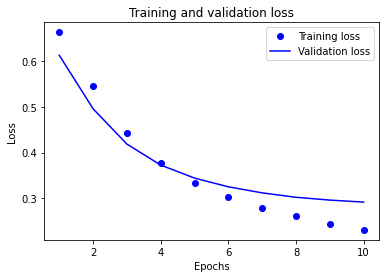

In [35]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

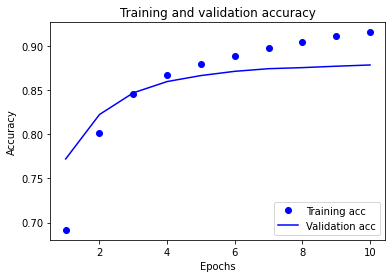

In [36]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [37]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 13s 16ms/step - loss: 0.3082 - accuracy: 0.8733
0.8726000189781189


In [38]:
example =[ "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."]

In [39]:
export_model.predict(example)

array([[0.5962841 ],
       [0.41751102],
       [0.33775765]], dtype=float32)

In [41]:
export_model.predict_classes(example)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1],
       [0],
       [0]], dtype=int32)